# **Audacity dei poveri - Progetto FESI Audio**
## **Applicazione di filtri nelle frequenze e nel tempo**
### Kevin Cattaneo
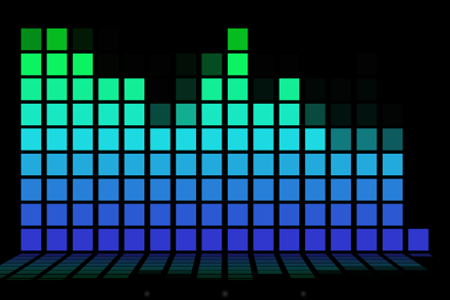
### **Obiettivo**
L'idea del progetto è esplorare alcuni filtri per la manipolazione dei suoni offerti all'interno del software [Audacity](https://www.audacityteam.org/), con l'obiettivo di analizzare come effettivamente questi filtri lavorano, cercando di ottenere tramite Python e le sue librerie delle operazioni quanto più verosimili a quelle eseguite nella realtà.

### **Indice**
  - Enhancement / rimozione di bassi e alti
  - Riduzione del rumore
  - Reverse (inversione nel tempo) 
  - Amplificazione / attenuazione dell'intensità del suono (volume)
  - Dissolvenza in entrata e in uscita
  - Generazione e addizione di rumore addizionato a un suono
  - Cambiamento velocità
<br><br>
(Per alcune voci visionare il notebook completo)


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import wave
import audioop
import struct
import scipy.io.wavfile as wav
import random, struct
import IPython
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

## Importazione del segnale audio

Importiamo un audio già modificato in un unico canale (mono) e in formato '.wav'. Sfruttiamo le librerie per caricare l'audio nel notebook.
<br><br>
Il nostro segnale audio sarà formato da sample organizzati all'interno di un array; la dimensione di questo array sarà il numero di sample presenti nel nostro audio. Il prodotto fra i sample e 1/frequenza di campionamento (ovvero il 'tempo' di ciascun sample, fornisce la durata del nostro audio. 

In [3]:
song_name ="sisters-voices.wav"
sr, audio_signal = wav.read(song_name) # This command loads the wavfile as (sample_rate, audio signal)
N = len(audio_signal) # length of audio = number of frames
time  = 1/sr * np.arange(N) # duration of audio

Ora utilizziamo la libreria IPython per poter ascoltare l'audio caricato

In [4]:
IPython.display.Audio(song_name, rate = sr)

Visualizziamo sul grafico l'audio riprodotto. Sulle ordinate possiamo osservare i valori assunti dai singoli sample che formano il segnale audio, sulle ascisse il tempo in secondi.

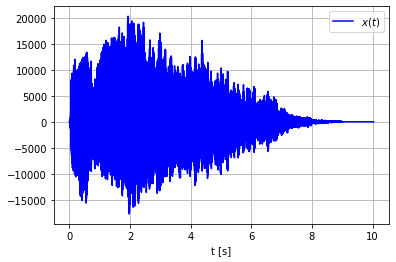

In [5]:
plt.plot(time, audio_signal,'-b',label=r"$x(t)$")
plt.xlabel('t [s]')
plt.legend()
plt.grid()

## La frequenza del segnale audio

Procediamo dunque con il calcolo, tramite funzioni di libreria di numpy, della trasformata di Fourier, in modo tale da poter operare in seguito anche sulle frequenze. 

In [6]:
# Fourier calculation
Fourier_signal = np.fft.fft(audio_signal) 
freq_signal = np.fft.fftfreq(N, 1/sr)

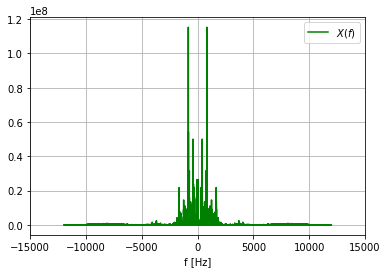

In [7]:
# Fourier plot
plt.plot(freq_signal,np.abs(Fourier_signal),'-g',label=r"$X(f)$")
plt.xlabel('f [Hz]')
plt.xlim([-15000,15000]) # audible frequencies
plt.legend()
plt.grid()

Dal grafico possiamo notare un insieme prevalente di basse frequenze (< 2500)

## Funzioni ausiliarie
Una serie di funzioni ausiliarie progettate per pura eleganza di codice

In [8]:
# Function to plot original and filtered Fourier graphics, with zoom
def plot_orig_mod(orig, mod, z=0):
  # Plot
  plt.figure(figsize=(10,6))
  # of original Fourier
  plt.subplot(2,2,1)
  plt.plot(freq_signal,np.abs(orig),'-b',label=r"$Y(f)$")
  plt.xlabel('f [Hz]')
  plt.xlim([-20000,20000])
  plt.legend()
  plt.tight_layout(pad=3.0)
  plt.title("Original Fourier")
  plt.grid()

  # of filtered Fourier
  plt.subplot(2,2,2)
  plt.plot(freq_signal,np.abs(mod),'-r',label=r"$Y(f)$")
  plt.xlabel('f [Hz]')
  plt.xlim([-20000,20000])
  plt.legend()
  plt.tight_layout(pad=3.0)
  plt.title("Filtered Fourier")
  plt.grid()

  if(z == 0): return
  # of zoomed original Fourier
  plt.subplot(2,2,3)
  plt.plot(freq_signal,np.abs(orig),'-b',label=r"$Y(f)$")
  plt.xlabel('f [Hz]')
  plt.xlim([-5000,5000])
  plt.legend()
  plt.tight_layout(pad=3.0)
  plt.title("Zoomed Original Fourier")
  plt.grid()

  # of zoomed filtered Fourier
  plt.subplot(2,2,4)
  plt.plot(freq_signal,np.abs(mod),'-r',label=r"$Y(f)$")
  plt.xlabel('f [Hz]')
  plt.xlim([-5000,5000])
  plt.legend()
  plt.tight_layout(pad=3.0)
  plt.title("Zoomed Filtered Fourier")
  plt.grid()

In [9]:
# Function to plot the spectrum
def plot_myspec(signal1, signal2, sample_rate):
  plt.figure(figsize=(10,4))
  plt.subplot(1,2,1)
  powerSpectrum, freqenciesFound, _time, imageAxis = plt.specgram(np.abs(signal1), Fs=sample_rate,NFFT=1024)
  plt.tight_layout(pad=3.0)
  plt.xlabel('Time')
  plt.ylabel('Frequency')
  plt.ylim([0,300])
  plt.title("Original signal")
  plt.colorbar()
  plt.subplot(1,2,2)
  powerSpectrum, freqenciesFound, _time, imageAxis = plt.specgram(np.abs(signal2), Fs=sample_rate,NFFT=1024)
  plt.tight_layout(pad=3.0)
  plt.xlabel('Time')
  plt.ylabel('Frequency')
  plt.ylim([0,300])
  plt.title("Filtered signal")
  plt.colorbar()

In [10]:
# Plot of two graphics
def simple_plot(audio_signal1, audio_signal2, title1 = "Original Audio", title2 = "Filtered Audio", inf=0, sup=10):
  plt.figure(figsize=(10,4))
  plt.subplot(1,2,1)
  plt.plot(time, audio_signal1[:N],'-b',label=r"$y(t)$")
  plt.title(title1)
  plt.grid()
  plt.xlim([inf,sup])
  plt.subplot(1,2,2)
  plt.plot(time, audio_signal2[:N],'-r',label=r"$y(t)$ filtered")
  plt.title(title2)
  plt.grid()
  plt.xlim([inf,sup])

## Applicazione dei filtri su frequenze

Iniziamo ora con l'applicazione di filtri, partendo con dei modificatori di frequenze

### Rimozione bassi

[Fonte: https://consigliveloci.it/quali-sono-le-frequenze-alte/ ]
<br>
Per modificare le frequenze basse si è attuata una selezione di indici dell'array relativo alla trasformata di Fourier. Tali indici vengono presi relativamente a un valore di frequenza corrispondente al tipo: per le basse si è valutato un valore di 500 Hz (tale da decretare un effettiva differenza dall'audio originale.
<br><br>
Per osservare la modifica sulle frequenze si procede con la visualizzazione della trasformata su grafico. Effettuando uno zoom si osserva un azzeramento delle basse frequenze.

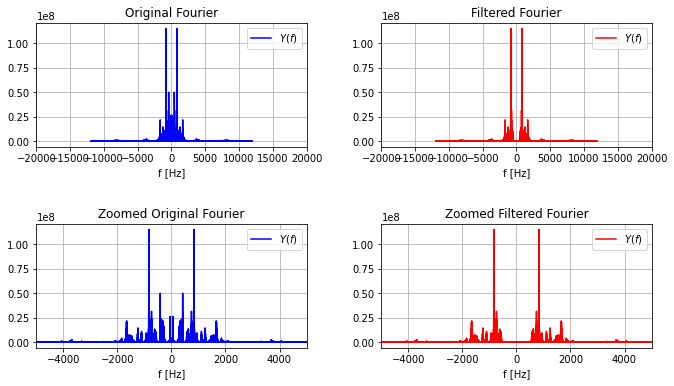

In [11]:
Fourier_filtered=Fourier_signal.copy()
indici = np.argwhere(abs(freq_signal)<500)

Fourier_filtered[indici]=0;

# Plot
plot_orig_mod(Fourier_signal, Fourier_filtered, 1)

Ora osserviamo nel tempo la differenza fra il suono originale e quello filtrato. Per farlo sfruttiamo la trasformata inversa di Fourier filtrato per tornare nel dominio temporale. Nel grafico sottostante possiamo osservare una differenza ridotta dovuta alla poca presenza di basse frequenze nel nostro segnale.

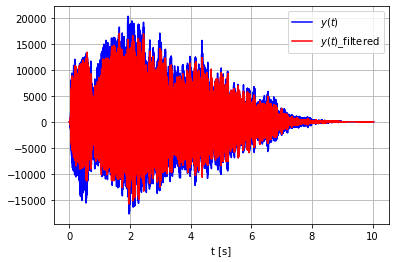

In [12]:
# Plot of original audio signal and the filtered one, one above the other
filtered_signal = np.fft.ifft(Fourier_filtered)

plt.plot(time, audio_signal[:N],'-b',label=r"$y(t)$")
plt.plot(time, filtered_signal[:N],'-r',label=r"$y(t)$_filtered")

plt.xlabel('t [s]')
plt.legend()
plt.grid()

Ora ascoltiamo il nuovo segnale audio filtrato

In [13]:
IPython.display.Audio(filtered_signal,rate=sr)

### Accentuazione alti

In questo caso si consiglia di iniziare a filtrare da un valore di frequenza pari a 2500, poichè da 5000 il segnale audio potrebbe iniziare a 'fischiare'.

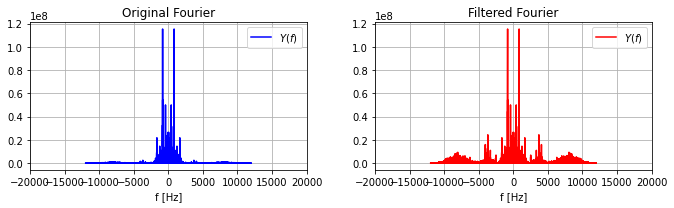

In [14]:
Fourier_filtered = Fourier_signal.copy()
indici = np.argwhere(abs(freq_signal)>2500)

Fourier_filtered[indici]*=10;

#Plot
plot_orig_mod(Fourier_signal, Fourier_filtered)

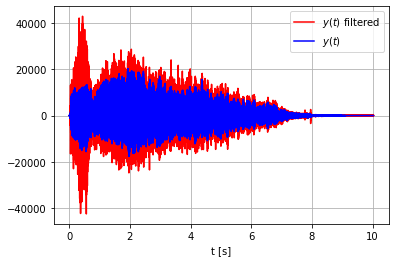

In [15]:
# Plot of original signal and the filtered one
filtered_signal = np.fft.ifft(Fourier_filtered)

plt.plot(time, filtered_signal[:N],'-r',label=r"$y(t)$ filtered")
plt.plot(time, audio_signal[:N],'-b',label=r"$y(t)$")
plt.xlabel('t [s]')
plt.legend()
plt.grid()

Osserviamo ora lo spettrogramma dei due segnali audio a confronto. Lo spettrogramma ci permette di visualizzare l'intensità del segnale audio nel tempo. Si può notare una maggiore presenza di tinte fredde nell'audio filtrato, questo dovuto al fatto che questo presenta una minore intensità (potenza),fornita con molta probabilità dalle componenti a basse frequenze precedentemente.

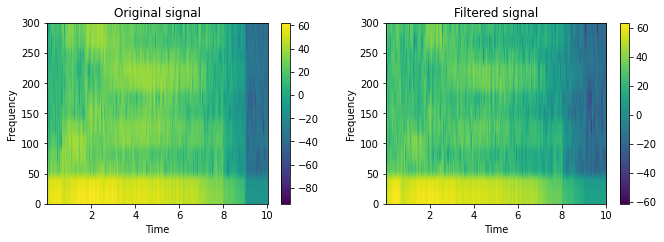

In [16]:
# Spectrum visualization
plot_myspec(audio_signal, filtered_signal, sr)

In [17]:
IPython.display.Audio(filtered_signal,rate=sr)

### Riduzione rumore 
#### mediante un filtro Gaussiano passa-basso 

Procediamo ora all'applicazione di un filtro Gaussiano passa-basso per ridurre il rumore all'interno del nostro segnale audio.
<br>
Con un po' di attenzione, relativamente a un segnale audio come una canzone, si può udire un suono più dolce nelle transizioni fra variazioni di tono medio-grandi. Nel complesso però un segnale sonoro come una canzone non subisce grandi trasformazioni da parte di questo filtro. 

In [18]:
def gaussian(sigma,n):
    x = np.linspace(-n//2,n//2, n)
    bump = np.exp(-x**2/2.*sigma**2)
    bump /= np.trapz(bump) # normalize the integral to 1
    #bump /= -np.trapz(bump) # high pass filter
    return x, bump

In [19]:
Fourier_filtered = Fourier_signal.copy()

x,y = gaussian(0.5,N) # lower than 0.2 can be destructive 

y_shifted = np.fft.fftshift(y)
fft_gauss = np.fft.fft(y_shifted)

In [20]:
fft_filt = np.multiply(Fourier_filtered,fft_gauss)

Text(0.5, 1.0, 'Filtered Fourier')

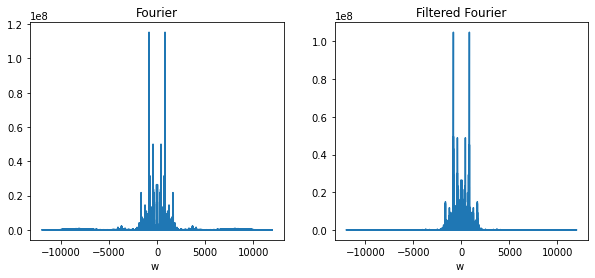

In [21]:
f_s = sr; #sampling frequency
n = len(fft_filt)
freq = np.fft.fftfreq(n, 1/f_s)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(freq,np.abs(Fourier_filtered)) 
plt.xlabel("w ")
plt.title("Fourier")
plt.subplot(1,2,2)
plt.plot(freq,np.abs(fft_filt))  
plt.xlabel("w ")
plt.title("Filtered Fourier")

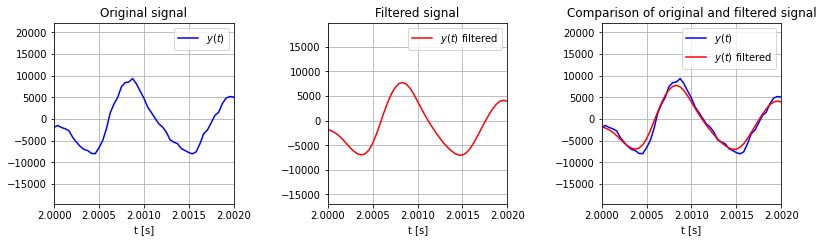

In [22]:
filtered_signal = np.fft.ifft(fft_filt)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.plot(time, audio_signal,'-b',label=r"$y(t)$")
plt.xlabel('t [s]')
plt.title("Original signal")
plt.legend()
plt.grid()
plt.xlim([2,2.002])
plt.tight_layout(pad=3.0)

plt.subplot(1,3,2)
plt.plot(time, filtered_signal[:N],'-r',label=r"$y(t)$ filtered")
plt.xlabel('t [s]')
plt.title("Filtered signal")
plt.legend()
plt.grid()
plt.tight_layout(pad=3.0)
plt.xlim([2,2.002])

plt.subplot(1,3,3)
plt.plot(time, audio_signal,'-b',label=r"$y(t)$")
plt.plot(time, filtered_signal[:N],'-r',label=r"$y(t)$ filtered")
plt.xlabel('t [s]')
plt.title("Comparison of original and filtered signal")
plt.legend()
plt.grid()
plt.xlim([2,2.002])
plt.tight_layout(pad=3.0)

Effettuando un grande zoom su una parte del nostro segnale possiamo apprezzare la differenza fra il segnale filtrato e quello originale, notando una curva più dolce e armonico quando la gaussiana viene applicata al segnale originale.

In [23]:
IPython.display.Audio(filtered_signal,rate=sr)

## Applicazione dei filtri sui sample
Osserviamo ora il comportamento di alcuni filtri che operano direttamente sull'array dei sample del nostro segnale audio e non più sulle frequenze.

### Inversione (reverse)

Per effettuare il reverse di una canzone, procediamo con l'operazione di reversing degli elementi (sample) dell'array relativo nostro audio.

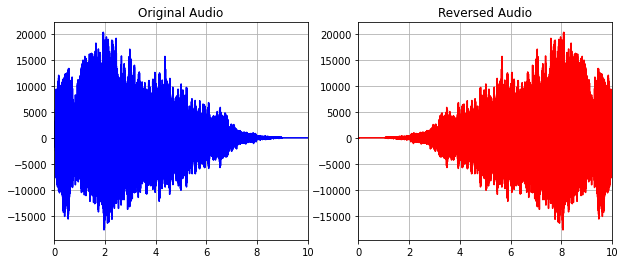

In [24]:
reversed_signal = audio_signal[::-1]
simple_plot(audio_signal, reversed_signal, "Original Audio", "Reversed Audio")

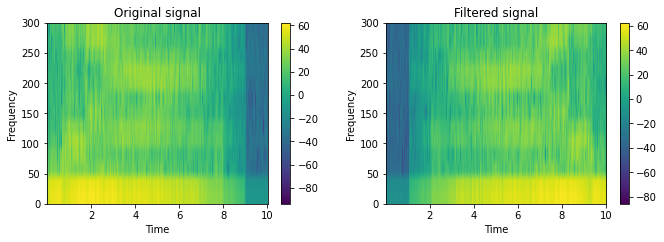

In [25]:
# Spectrum visualization
plot_myspec(audio_signal, reversed_signal, sr)

In [26]:
IPython.display.Audio(reversed_signal, rate = sr)

### Amplificazione

L'amplificazione sfrutta la libreria audioop e in particolare la sua funzione di moltiplicazione per un fattore del valore di ogni sample presente nell'array, il tutto in una maniera più 'safe' e meno distruttiva, operando su insiemi di byte-like-objects. In realtà la 'distruttività' del segnale prodotto dipende dal fattore di amplificazione applicato.
<br>
Si può infatti notare come il semplice e diretto prodotto per un fattore applicato ai valori dell'array porta a un'operazione più distruttiva del segnale audio, questo molto probabilmente perchè si viene ad aumentare notevolmente il valore di alcuni sample già di per sè di tonalità molto alta, creando così un sample "sporco".

In [27]:
def amplify(input_wav, output_wav, multiplier, by_hand = 0):
  # with library
  if(by_hand == 0):
    with wave.open(input_wav, 'rb') as wav:
        p = wav.getparams()
        with wave.open(output_wav, 'wb') as audio:
            audio.setparams(p)
            frames = wav.readframes(p.nframes)
            audio.writeframesraw(audioop.mul(frames, p.sampwidth, multiplier))
  else:
      # manually operating on samples
      signal_copy = audio_signal.copy()
      for i in range(0, len(signal_copy)):
        signal_copy[i] = signal_copy[i]*multiplier

      changed_output = wave.open(output_wav, 'wb')
      changed_output.setparams((1, 2, sr, 0, 'NONE', 'not compressed'))

      values = []

      for i in range(0, len(signal_copy)):
        value = signal_copy[i]
        packed_value = struct.pack('h', value)
        values.append(packed_value)

      value_str = b''.join(values)
      changed_output.writeframes(value_str)
      changed_output.close()

In [28]:
amplify(song_name, 'amplified.wav', 5, 0);

Visualizzando lo spettrogramma si può notare una maggiore energia (intensità di suono) nel segnale (una leggerissima colorazione più calda)

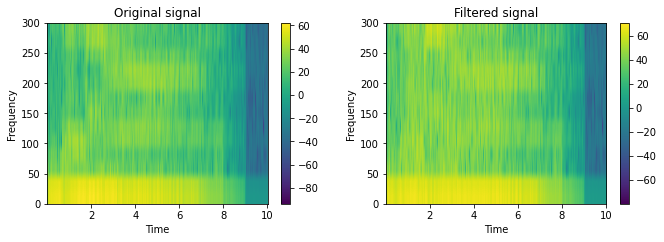

In [29]:
# Spectrum visualization
import scipy.io.wavfile as wav
sr, signal = wav.read("amplified.wav")
plot_myspec(audio_signal, signal, sr)

In [30]:
IPython.display.Audio("amplified.wav", rate = sr)

### Dissolvenza in entrata

Per la dissolvenza in entrata si è scelto di operare moltiplicando i primi N samples (durata dissolvenza * frequenza di campionamento) del segnale per un valore di funzione esponenziale che varia da una frazione di 1 a 1, ottenendo così un tono crescente nel tempo.

In [31]:
signal_copy = audio_signal.copy()
duration = 3
n_frame = duration * sr # range of frames

x = 0.1
idx = 1/n_frame # add a fraction idx to the x of the log: the resulting factor is between 0.1 and 1

# for i in range(16*sr, n_frame+(16*sr)): # if offset, e.g. 16*sr = beginning from the frame at 16 seconds
for i in range(0, n_frame):
  signal_copy[i] = signal_copy[i] * np.exp(2 * x - 2)
  x += idx

changed_output = wave.open('dissolve_enter.wav', 'wb')
changed_output.setparams((1, 2, sr, 0, 'NONE', 'not compressed'))

values = []

for i in range(0, len(signal_copy)):
	value = signal_copy[i]
	packed_value = struct.pack('h', value)
	values.append(packed_value)

value_str = b''.join(values)
changed_output.writeframes(value_str)
changed_output.close()

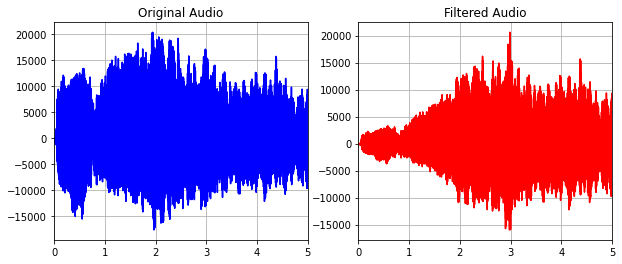

In [32]:
simple_plot(audio_signal, signal_copy, inf = 0, sup = 5)

In [33]:
IPython.display.Audio("dissolve_enter.wav", rate = sr)

### Generazione rumore

Per la generazione del rumore si è scelto di creare un array di valori interi generati in modo casuale. Tali valori vengono poi inseriti in un file .wav mediante funzioni di libreria apposite

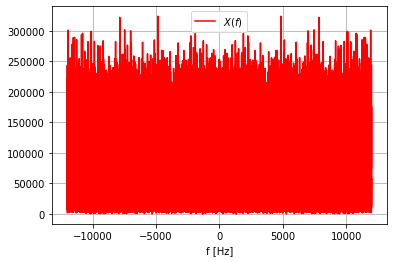

In [34]:
duration = int(N / sr)
SAMPLE_LEN = N  # 30 seconds of random audio

noise_output = wave.open('noise.wav', 'wb')
noise_output.setparams((1, 2, sr, 0, 'NONE', 'not compressed'))

values = []

for i in range(0, SAMPLE_LEN):
	value = random.randint(-32767//100, 32767//100) # regolate volume
	packed_value = struct.pack('h', value)
	values.append(packed_value)

value_str = b''.join(values)
noise_output.writeframes(value_str)
noise_output.close()

 # Frequency plot
sr_noise, noise_signal = wav.read('noise.wav')
N_noise = len(noise_signal)
Fourier_noise = np.fft.fft(noise_signal) 
freq_noise = np.fft.fftfreq(N_noise, 1/sr_noise)

plt.plot(freq_noise,np.abs(Fourier_noise),'-r',label=r"$X(f)$")
plt.xlabel('f [Hz]')
plt.legend()
plt.grid()

Possiamo così ascoltare il rumore generato

In [35]:
IPython.display.Audio("noise.wav", rate = sr_noise)

Adesso addizioniamo il nostro rumore al segnale audio originale

In [36]:
with wave.open(song_name, "rb") as infile:
    # get file data
    nchannels = infile.getnchannels()
    sampwidth = infile.getsampwidth()
    framerate = infile.getframerate()
    # set position in wave to start of segment
    infile.setpos(int(0.0 * framerate))
    # extract data
    data = infile.readframes(int((duration) * framerate))

with wave.open('noise.wav', "rb") as infile_noise:
    # get file data
    nchannels = infile_noise.getnchannels()
    sampwidth = infile_noise.getsampwidth()
    framerate = infile_noise.getframerate()
    # set position in wave to start of segment
    infile_noise.setpos(int(0.0 * framerate))
    # extract data
    data_noise = infile_noise.readframes(int((duration) * framerate))

with wave.open('noisy_res.wav', 'wb') as outfile:
    outfile.setnchannels(nchannels)
    outfile.setsampwidth(sampwidth)
    outfile.setframerate(framerate)
    outfile.setnframes(int(len(data) / sampwidth))
    outfile.writeframesraw(audioop.add(data, data_noise, 1))

Ora possiamo ascoltare la somma dei due segnali audio

In [37]:
IPython.display.Audio("noisy_res.wav", rate = sr)

### Cambiamento di velocità

Il cambiamento di velocità lo si può operare in due modi i cui prodotti sono molto simili:
- è possibile leggere il file .wav e riscriverlo con una frequenza di campionamento diversa di un certo fattore
- oppure è possibile applicare un subsampling dell'array (compressione) oppure un'espansione
<br>Nel secondo caso un orecchio attento può riscontrare un suono più piatto e meno 'dolce' nelle transizioni di tono

In [38]:
# By changing framerate (lossless)

with wave.open(song_name, "rb") as infile:
    # get file data
    nchannels = infile.getnchannels()
    sampwidth = infile.getsampwidth()
    framerate = infile.getframerate()
    # set position in wave to start of segment
    infile.setpos(int(0.0 * framerate))
    # extract data
    data = infile.readframes(int((duration) * framerate))

with wave.open('faster.wav', 'wb') as outfile:
    outfile.setnchannels(nchannels)
    outfile.setsampwidth(sampwidth)
    outfile.setframerate(framerate*2) # sampling di un array (no funzioni di libreria)
    #outfile.setframerate(framerate/2) # per ridurre la velocità
    outfile.setnframes(int(len(data) / sampwidth))
    outfile.writeframesraw(audioop.mul(data, sampwidth, 1))

In [39]:
IPython.display.Audio("faster.wav", rate = sr)

Il subsampling dell'array per velocizzare il segnale audio procede nel contrassegnare un elemento (sample) sì e un elemento no dell'array originale, producendo dei 'buchi'. Tali buchi vengono infine rimossi, di fatto comprimendo l'array. Il risultato è un segnale audio con una velocità maggiore.

In [40]:
# By subsampling the signal array
signal_copy = audio_signal.copy()

subsample = signal_copy[::2] # view on signal_copy (not a copy, so if modified, modify signal_copy)
subsample[:] = -1
changed_signal = np.delete(signal_copy, np.where(signal_copy == -1))

changed_output = wave.open('faster.wav', 'wb')
changed_output.setparams((1, 2, sr, 0, 'NONE', 'not compressed'))

values = []

for i in range(0, len(changed_signal)):
	value = changed_signal[i]
	packed_value = struct.pack('h', value)
	values.append(packed_value)

value_str = b''.join(values)
changed_output.writeframes(value_str)
changed_output.close()

In [41]:
IPython.display.Audio("faster.wav", rate = sr)

Per rallentare il segnale audio si adotta un'operazione di espansione dell'array che procede nel prendere ogni elemento dell'array originale e ne copia il valore nella posizione successiva. Ovviamente dopo aver inserito si salta tale elemento (procedendo di due posizioni), evitando di copiare lo stesso valore per tutta la durata del segnale audio. L'array viene di fatto esteso e il risultato è un segnale audio con una velocità ridotta.
<br><br>
Nota: a seconda della durata del segnale audio e, quindi, la grandezza dell'array, tale operazione può prendere molto tempo

In [42]:
# By expanding the signal array
signal_copy = audio_signal.copy()

for i in range(0, len(signal_copy)*2): # must consider a 2 * size since every element is doubled (the len(signal_copy) isn't updated during the loop; otherwise it stops at previous audio length!)
 if(i % 2 == 0):
    signal_copy = np.insert(signal_copy, i+1, signal_copy[i])

changed_output = wave.open('slower.wav', 'wb')
changed_output.setparams((1, 2, sr, 0, 'NONE', 'not compressed'))

values = []

for i in range(0, len(signal_copy)): # here len(signal_copy) is already updated
	value = signal_copy[i]
	packed_value = struct.pack('h', value)
	values.append(packed_value)

value_str = b''.join(values)
changed_output.writeframes(value_str)
changed_output.close()

In [43]:
IPython.display.Audio("slower.wav", rate = sr)